In [1]:
import sys
sys.path.append('..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
import seaborn as sns
from IPython.display import clear_output
from constants.coin_list import COIN_LIST
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns
from utilities.bt_analysis import sa_backtest_analysis, get_metrics
from utilities.plot_analysis import plot_bar_by_month, plot_equity_vs_asset, plot_trade_analysis
import pandas_market_calendars as mcal

ModuleNotFoundError: No module named 'constants'

In [ ]:
exchange_name = "binance"
pair = "BTC/USDT"
tf = "1h"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)

# df = df.reset_index()
df["date"] = df.index.values

df["year"] = df["date"].dt.year
df["month_name"] = df["date"].dt.month_name()
df["month"] = df["date"].dt.month - 1
df["day"] = df["date"].dt.day_of_week
df["hour"] = df["date"].dt.hour

df["usd_volume"] = df["volume"] * df["close"]
df["return"] = df["close"] - df["open"]
df["return_pct"] = ((df["close"] - df["open"]) / df["open"]) * 100
df["volatility"] = df["high"] - df["low"]
df["volatility_pct"] = ((df["high"] - df["low"]) / df["low"]) * 100

df["return"] = df["close"] - df["open"]
df["return_pct"] = ((df["close"] - df["open"]) / df["open"]) * 100

for stock_ex in ["EUREX", "JPX", "SSE", "NYSE"]:
    nyse = mcal.get_calendar(stock_ex)
    schedule = nyse.schedule(start_date='2017-01-01', end_date='2022-09-26')
    df["market_open"] = schedule["market_open"]
    df["market_close"] = schedule["market_close"]
    df.loc[df["market_open"] == "NaT", "market_open"] = np.nan
    df.loc[df["market_close"] == "NaT", "market_close"] = np.nan
    df["market_open"].fillna(method='ffill', inplace=True)
    df["market_close"].fillna(method='ffill', inplace=True)
    df["market_open"] = df["market_open"].apply(lambda x: x.tz_convert(None))
    df["market_close"] = df["market_close"].apply(lambda x: x.tz_convert(None))
    df[stock_ex + "_open"] = False
    df.loc[(df["date"] > df["market_open"]) & (df["date"] < df["market_close"]), stock_ex + "_open"] = True
    del df["market_close"]
    del df["market_open"]

# df.loc[(df["date"] > df["market_open"]) & (df["date"] < df["market_close"]), "NYSE_open"] = True
# df.loc[df["NYSE_open"] == True]

In [ ]:
grouper = "hour"
analyser = "return_pct"
dt = pd.DataFrame(df.loc[df["NYSE_open"] == True].groupby(grouper)[analyser].mean().sort_index())
dt

,return_pct
hour,
14,-0.037425
15,0.058767
16,-0.008461
17,-0.039134
18,-0.007067
19,0.040310
20,0.031842


--- Data since 2021 ---


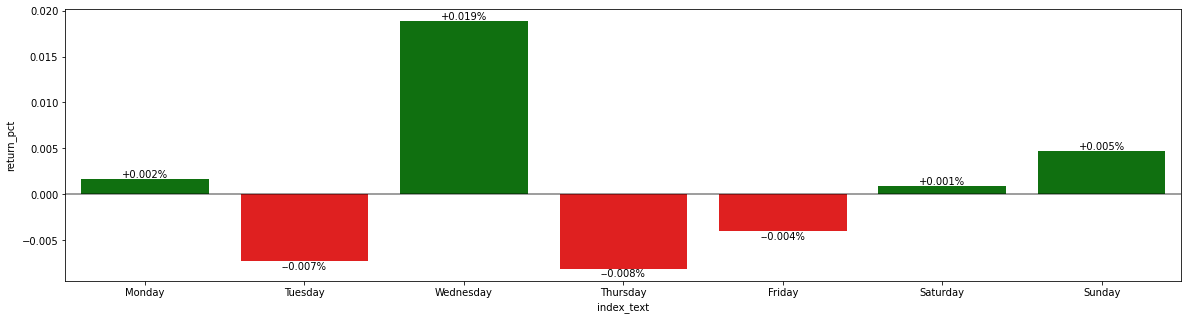

--- Data until 2020 ---


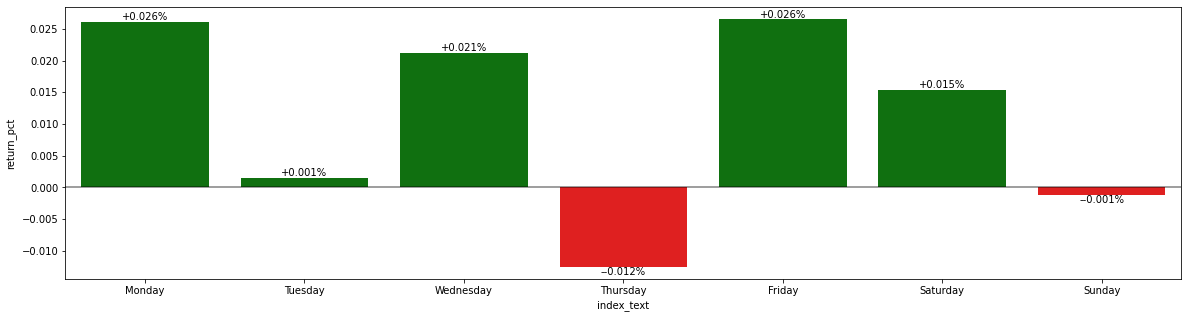

In [ ]:
grouper = "day" # hour day month EUREX_open JPX_open SSE_open NYSE_open
analyser = "return_pct" # volume return_pct volatility_pct 

for i in range(2):
    if i == 0:
        print("--- Data since 2021 ---")
        dt = pd.DataFrame(df.loc[df["date"] > "2021"].groupby(grouper)[analyser].mean().sort_index())
    else:
        print("--- Data until 2020 ---")
        dt = pd.DataFrame(df.loc[df["date"] < "2021"].groupby(grouper)[analyser].mean().sort_index())
    # dt["index_text"] = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    dt["index_text"] = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    # dt["index_text"] = ["0h","1h","2h","3h","4h","5h","6h","7h","8h","9h","10h","11h","12h","13h","14h","15h","16h","17h","18h","19h","20h","21h","22h","23h"]
    # dt["index_text"] = ["Market_closed", "Market_open"]

    fig, ax_left = plt.subplots(figsize=(20, 5))

    custom_palette = {}
    for index, row in dt.iterrows():
        if row[analyser] >= 0:
            custom_palette[row["index_text"]] = 'g'
        else:
            custom_palette[row["index_text"]] = 'r'
    g = sns.barplot(ax=ax_left, data=dt, x='index_text',y=analyser, palette=custom_palette)
    for index, row in dt.iterrows():
        if row[analyser] >= 0:
            g.text(row.name, row[analyser], '+'+str(round(row[analyser], 3))+'%', color='black', ha="center", va="bottom")
        else:
            g.text(row.name, row[analyser], '-'+str(round(row[analyser], 3))+'%', color='black', ha="center", va="top")
    ax_left.axhline(y=0, color='black', alpha=0.5)
    plt.show()